In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


## INSULIN INTAKE DAILY

In [ ]:
# First load files pp
insulin_data = pd.read_csv('') # Specify the path to your insulin data file
# Ensure the timestamp is in datetime format and create a 'day' column
insulin_data['timestamp'] = pd.to_datetime(insulin_data['timestamp'])
insulin_data['day'] = insulin_data['timestamp'].dt.date + pd.Timedelta(days=1)

In [18]:
basal = insulin_data[['day','infused']]
bolus = insulin_data[['day','bolus_insulin','timestamp']]

np.random.seed(42)  # For reproducibility, optional
insulin_data['infused'] = np.random.uniform(0, 3, size=len(insulin_data))
insulin_data['bolus_insulin'] = np.random.uniform(0, 10, size=len(insulin_data))

In [19]:
daily_basal = basal.groupby('day')['infused'].sum().reset_index()
daily_basal['infused'] = daily_basal['infused']/20 # every hour instead of every 3 minutes

daily_bolus = bolus.groupby('day')['bolus_insulin'].sum().reset_index()

daily_all = pd.DataFrame()
daily_all['day'] = daily_bolus['day']
daily_all['insulin'] = daily_bolus['bolus_insulin']/100 + daily_basal['infused']/10

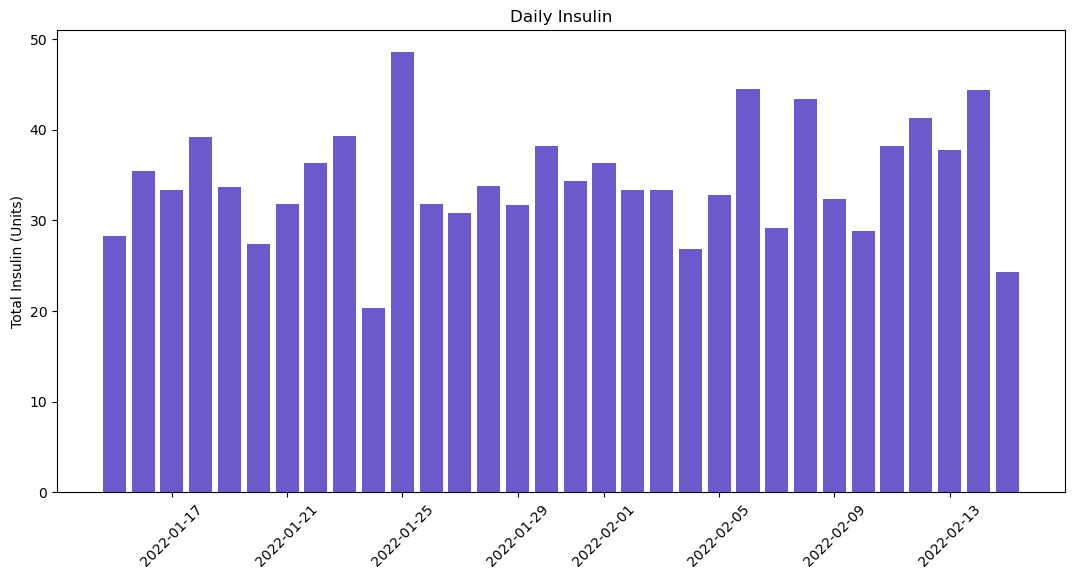

In [20]:
plt.figure(figsize=(13, 6)) 

plt.bar(daily_all['day'], daily_all['insulin'],color='slateblue')

plt.ylabel('Total Insulin (Units)')
plt.title('Daily Insulin')

plt.xticks(rotation=45)

plt.show()

## GLUCOSE ANALYSIS

In [ ]:
glucose = pd.read_csv('') # Specify the path to your glucose data file
filtered_glucose = glucose[glucose['patient']==patient]

np.random.seed(42)  # For reproducibility, optional
filtered_glucose['glucose'] = filtered_glucose['glucose'] + np.random.uniform(0, 50, size=len(filtered_glucose))

filtered_glucose = filtered_glucose.copy()
filtered_glucose.loc[:, 'day'] = pd.to_datetime(filtered_glucose['timestamp']).dt.date

/var/folders/vw/gq8nz2cx3kx401ysxmns_yrc0000gn/T/ipykernel_39440/1588555880.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Get rid of trial glucose week

In [ ]:
common_days = filtered_glucose['day'].isin(insulin_data['day'])
filtered_glucose = filtered_glucose[common_days]

In [23]:
mean_glucose_overall = round(filtered_glucose['glucose'].mean(), 1)
median_glucose_overall = filtered_glucose['glucose'].median()
std_glucose_overall = filtered_glucose['glucose'].std()
print('Mean CGM: ',mean_glucose_overall,'mg/dL')
print('Median CGM: ',median_glucose_overall,'mg/dL')
print('IoV: ',round(std_glucose_overall*100/mean_glucose_overall, 1), '%')
print('GMI: ', round(0.02392*mean_glucose_overall+2.441, 1),'% (less than 7% is good)')
#Index of variability


Mean CGM:  189.0 mg/dL
Median CGM:  184.83773721398728 mg/dL
IoV:  29.8 %
GMI:  7.0 % (less than 7% is good)


Everyday glucose plot

In [ ]:
import pandas as pd
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, Input, Output


CGM_allpatients = pd.read_csv("") # Specify the path to your CGM data file
CGM_allpatients['timestamp'] = pd.to_datetime(CGM_allpatients['timestamp'], format='%Y-%m-%d %H:%M:%S')
PIE_all = pd.read_csv('')   # Specify the path to your PIE data file
PIE_all['timestamp'] = pd.to_datetime(PIE_all['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')



# Filter glucose data for the selected patient and trim from the starting day of the force data
CGM_allpatients = CGM_allpatients[CGM_allpatients['patient'] == selected_patient]
CGM_allpatients.set_index('timestamp', inplace=True)
glucose_resampled = CGM_allpatients.resample('5T').mean().interpolate()
glucose_resampled.reset_index(inplace=True)
glucose_resampled['time'] = glucose_resampled['timestamp'].dt.strftime('%H:%M')

def bootstrap_ci(data, num_samples=50, ci_percent=90):
    medians = []
    n = len(data)
    for _ in range(num_samples):
        resample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(resample))
    
    lower_bound = np.percentile(medians, (100 - ci_percent) / 2)
    upper_bound = np.percentile(medians, 100 - (100 - ci_percent) / 2)
    return lower_bound, upper_bound
    
window_size_glucose = 5
glucose_summary = glucose_resampled.groupby('time')['glucose'].agg(['median']).reset_index()
glucose_summary['CI_lower'], glucose_summary['CI_upper'] = zip(*glucose_resampled.groupby('time')['glucose'].apply(lambda x: bootstrap_ci(x.values)))
glucose_summary['smoothed_CI_lower'] = glucose_summary['CI_lower'].rolling(window=window_size_glucose, min_periods=1).mean()
glucose_summary['smoothed_CI_upper'] = glucose_summary['CI_upper'].rolling(window=window_size_glucose, min_periods=1).mean()


app = Dash(__name__)


app.layout = html.Div(children=[
    html.H3(f"Data for Patient: {selected_patient}", style={'text-align': 'center'}),
    
    html.Label(['Include PIE?'], style={'font-weight': 'bold', "text-align": "center"}),
    dcc.RadioItems(
        id='pie-radio',
        options=[
            {'label': 'Yes', 'value': 'y'},
            {'label': 'No', 'value': 'n'}
        ],
        value='n',  # Default to 'No'
        inline=True,
        style={
            'display': 'flex',
            'align-items': 'center',
            'margin-top': '5px',
            'margin-bottom': '15px',
        },
        labelStyle={
            'margin-right': '20px',
            'font-size': '16px',
            'color': 'black',
        }
    ),

    html.Label(['95% CI?'], style={'font-weight': 'bold', "text-align": "center"}),
    dcc.RadioItems(
        id='CI-radio',
        options=[
            {'label': 'Yes', 'value': 'y'},
            {'label': 'No', 'value': 'n'}
        ],
        value='n',  # Default to 'No'
        inline=True,
        style={
            'display': 'flex',
            'align-items': 'center',
            'margin-top': '5px',
            'margin-bottom': '15px',
        },
        labelStyle={
            'margin-right': '20px',
            'font-size': '16px',
            'color': 'black',
        }
    ),

    html.Label(['Include Force?'], style={'font-weight': 'bold', "text-align": "center"}),  # New Toggle
    dcc.RadioItems(
        id='force-radio',
        options=[
            {'label': 'Yes', 'value': 'y'},
            {'label': 'No', 'value': 'n'}
        ],
        value='n',  # Default to 'No'
        inline=True,
        style={
            'display': 'flex',
            'align-items': 'center',
            'margin-top': '5px',
            'margin-bottom': '15px',
        },
        labelStyle={
            'margin-right': '20px',
            'font-size': '16px',
            'color': 'black',
        }
    ),

    html.Hr(),
    dcc.Graph(figure={}, id='controls-and-graph')
])

@app.callback(
    Output('controls-and-graph', 'figure'),
    Input('pie-radio', 'value'),
    Input('CI-radio', 'value'),
    Input('force-radio', 'value')  # New Input for Force Toggle
)
def set_display_children(PIE_quest, CI_quest, force_quest):
    
    cgm_data = glucose_resampled
    pie_data = PIE_all[PIE_all["patient"] == selected_patient]
    
    
    cgm_data_filtered = cgm_data.copy()
    pie_data_filtered = pie_data.copy()
    force_data_filtered = force_data.copy()

    
    cgm_data_filtered['date'] = cgm_data_filtered['timestamp'].dt.date
    cgm_data_filtered['week'] = cgm_data_filtered['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

    pie_data_filtered['date'] = pie_data_filtered['timestamp'].dt.date
    pie_data_filtered['week'] = pie_data_filtered['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

    force_data_filtered['date'] = force_data_filtered['timestamp'].dt.date
    force_data_filtered['week'] = force_data_filtered['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

    grouped_weeks = cgm_data_filtered.groupby('week')
    
    num_weeks = len(grouped_weeks)
    fig = make_subplots(
        rows=num_weeks, cols=1,
        shared_xaxes=False,
        subplot_titles=[f"Week starting: {week.date()}" for week in grouped_weeks.groups],
        vertical_spacing=0.1,
        specs=[[{"secondary_y": True}] for _ in range(num_weeks)]  # Enable secondary y-axis
    )
    
    
    for i, (week, week_data) in enumerate(grouped_weeks, start=1):
        days_in_week = week_data.groupby(week_data['timestamp'].dt.weekday)
        
        fig.add_trace(
            go.Scatter(
                x=[week_data['timestamp'].min(), week_data['timestamp'].max()],
                y=[181, 181],
                mode='lines',
                line=dict(color='green', width=2),
                showlegend=False
            ),
            row=i, col=1
        )
        fig.add_trace(
            go.Scatter(
                x=[week_data['timestamp'].min(), week_data['timestamp'].max()],
                y=[69, 69],
                mode='lines',
                line=dict(color='green', width=2),
                showlegend=False
            ),
            row=i, col=1
        )
        
        fig.add_shape(
            type="rect",
            xref="x", yref="y",
            x0=week_data['timestamp'].min(), x1=week_data['timestamp'].max(),
            y0=70, y1=180,
            fillcolor="green",
            opacity=0.2,
            layer="below",
            line_width=0,
            row=i, col=1
        )

        
        for day, day_data in days_in_week:
            weekday_name = day_data['timestamp'].dt.strftime('%A').iloc[0]
            day_start = day_data['timestamp'].min()
            day_midpoint = day_start + (day_data['timestamp'].max() - day_start) / 2
            fig.add_shape(
                type="line",
                xref="x", yref="paper",
                x0=day_start, x1=day_start,
                y0=0, y1=350,
                line=dict(color="black", width=2),
                row=i, col=1
            )
            
            fig.add_trace(
                go.Scatter(
                    x=day_data['timestamp'], 
                    y=day_data['glucose'], 
                    mode='lines', 
                    line=dict(color='black'),
                    name=weekday_name,
                    showlegend=False
                ), 
                row=i, col=1
            )

            if CI_quest == 'y':
                
                fig.add_trace(
                    go.Scatter(
                        x=day_data['timestamp'],
                        y=glucose_summary['smoothed_CI_upper'],
                        mode='lines',
                        line=dict(color='rgba(178, 34, 34, 0.8)', width=2, dash='dot'),
                        showlegend=False
                    ),
                    row=i, col=1
                )
                fig.add_trace(
                    go.Scatter(
                        x=day_data['timestamp'],
                        y=glucose_summary['smoothed_CI_lower'],
                        mode='lines',
                        line=dict(color='rgba(178, 34, 34, 0.8)', width=2, dash='dot'),
                        showlegend=False
                    ),
                    row=i, col=1
                )

            
            if force_quest == 'y':
                force_day_data = force_data_filtered[force_data_filtered['timestamp'].dt.date == day_start.date()]
                if not force_day_data.empty:
                    fig.add_trace(
                        go.Scatter(
                            x=force_day_data['timestamp'],
                            y=force_day_data['force'],
                            mode='lines',
                            line=dict(color='blue'),
                            name=f"{weekday_name} Force",
                            opacity=0.5,
                            showlegend=False
                        ),
                        row=i, col=1, secondary_y=True  # Plot on secondary y-axis
                    )
            if PIE_quest == 'y':
                pie_day_data = pie_data_filtered[pie_data_filtered['timestamp'].dt.date == day_start.date()]
                if not pie_day_data.empty:
                    fig.add_trace(
                        go.Scatter(
                            x=pie_day_data['timestamp'], 
                            y=pie_day_data['PIE'] / 6,
                            mode='lines', 
                            line=dict(color='slateblue'),
                            name=f"{weekday_name} PIE",
                            opacity=0.8,
                            showlegend=False
                        ),
                        row=i, col=1
                    )
                                
            # Annotate the plot with the weekday name
            fig.add_annotation(
                x=day_midpoint, y=370,
                xref=f'x{i}', yref=f'paper',
                text=weekday_name,
                showarrow=False,
                font=dict(size=12, color="black"),
                row=i, col=1
            )
                    
        # Set y-axis range for glucose and secondary y-axis range for force
        fig.update_yaxes(range=[0, 400], row=i, col=1)
        fig.update_yaxes(range=[0, 13000], row=i, col=1, secondary_y=True)  # Secondary axis for force

    # Update layout for appearance
    fig.update_layout(
        height=400*num_weeks,
        title=f"Weekly Glucose and Force Levels for Patient {selected_patient}",
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)



What percent of the day is TIR.

In [25]:
def calculate_percentages(group):
    total_values = len(group)    
    below_54 = len(group[group['glucose'] < 54]) / total_values * 100 if total_values > 0 else 0
    between_54_69 = len(group[(group['glucose'] >= 54) & (group['glucose'] < 70)]) / total_values * 100 if total_values > 0 else 0
    in_range = len(group[(group['glucose'] >= 70) & (group['glucose'] <= 180)]) / total_values * 100 if total_values > 0 else 0
    between_181_250 = len(group[(group['glucose'] > 180) & (group['glucose'] <= 250)]) / total_values * 100 if total_values > 0 else 0
    above_250 = len(group[group['glucose'] > 250]) / total_values * 100 if total_values > 0 else 0
    
    return pd.Series({
        'percent_below_54': below_54,
        'percent_54_69': between_54_69,
        'percent_in_range': in_range,
        'percent_181_250': between_181_250,
        'percent_above_250': above_250
    })


daily_percentages = filtered_glucose.groupby('day').apply(calculate_percentages).reset_index()
overall_percentages = calculate_percentages(filtered_glucose).to_frame().transpose().reset_index(drop=True)


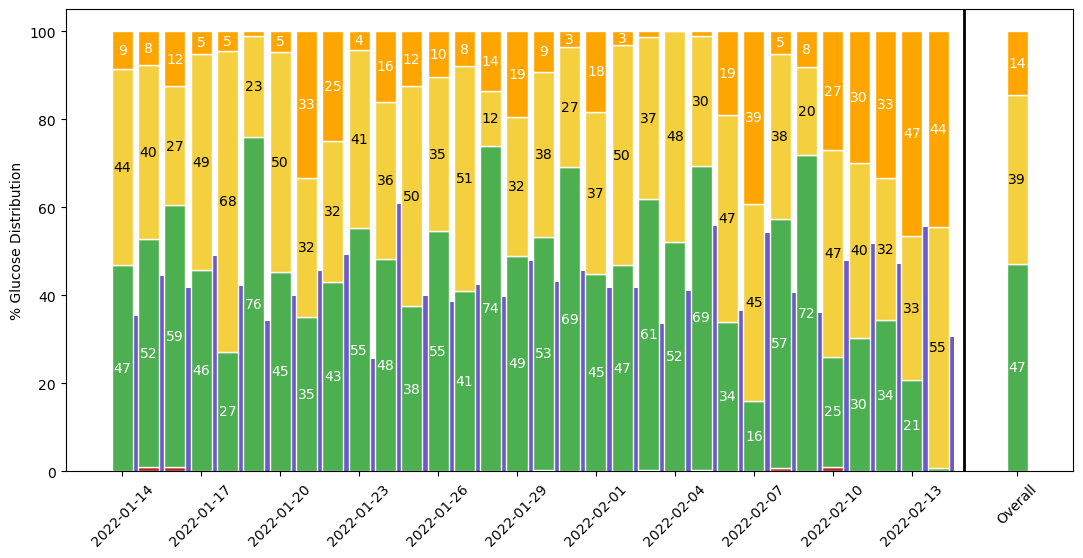

In [26]:
colors = {
    'below_54': 'saddlebrown',
    '54_69': 'firebrick',
    'in_range': '#4CAF50',
    '181_250': '#f4d03f',
    'above_250': 'orange'
}


plt.figure(figsize=(13, 6))

bars_below_54 = plt.bar(daily_percentages['day'], daily_percentages['percent_below_54'], color=colors['below_54'], edgecolor='white', linewidth=1, zorder=2)
bars_54_69 = plt.bar(daily_percentages['day'], daily_percentages['percent_54_69'], bottom=daily_percentages['percent_below_54'], color=colors['54_69'], edgecolor='white', linewidth=1, zorder=2)
bars_in_range = plt.bar(daily_percentages['day'], daily_percentages['percent_in_range'], 
                        bottom=daily_percentages['percent_below_54'] + daily_percentages['percent_54_69'], color=colors['in_range'], edgecolor='white', linewidth=1, zorder=2)
bars_181_250 = plt.bar(daily_percentages['day'], daily_percentages['percent_181_250'], 
                       bottom=daily_percentages['percent_below_54'] + daily_percentages['percent_54_69'] + daily_percentages['percent_in_range'], color=colors['181_250'], edgecolor='white', linewidth=1, zorder=2)
bars_above_250 = plt.bar(daily_percentages['day'], daily_percentages['percent_above_250'], 
                         bottom=daily_percentages['percent_below_54'] + daily_percentages['percent_54_69'] + daily_percentages['percent_in_range'] + daily_percentages['percent_181_250'], color=colors['above_250'], edgecolor='white', linewidth=1, zorder=2)

def add_labels(bars, heights, offsets, text_color='white'):
    for bar, height, offset in zip(bars, heights, offsets):
        if height > 2:  
            plt.text(bar.get_x() + bar.get_width() / 2, offset + height / 2, f'{height:.0f}', 
                     ha='center', va='center', color=text_color, fontsize=10)
first_day = min(daily_percentages['day'])
last_day = max(daily_percentages['day'])

add_labels(bars_below_54, daily_percentages['percent_below_54'], [0]*len(daily_percentages))
add_labels(bars_54_69, daily_percentages['percent_54_69'], daily_percentages['percent_below_54'])
add_labels(bars_in_range, daily_percentages['percent_in_range'], daily_percentages['percent_below_54'] + daily_percentages['percent_54_69'])
add_labels(bars_181_250, daily_percentages['percent_181_250'], daily_percentages['percent_below_54'] + daily_percentages['percent_54_69'] + daily_percentages['percent_in_range'], text_color='black')  # Set black for yellow bars
add_labels(bars_above_250, daily_percentages['percent_above_250'], daily_percentages['percent_below_54'] + daily_percentages['percent_54_69']+ daily_percentages['percent_in_range'] + daily_percentages['percent_181_250'])



insulin_positions = daily_percentages['day'] 
plt.bar(insulin_positions, daily_all['insulin']*1.25 ,color='slateblue', width=0.6, alpha=1, label='Daily Insulin', align= 'edge', zorder=1)


overall_below_54 = plt.bar(last_day + timedelta(days=3), overall_percentages['percent_below_54'], color=colors['below_54'], edgecolor='white', linewidth=1)
overall_54_69 = plt.bar(last_day + timedelta(days=3), overall_percentages['percent_54_69'], bottom=overall_percentages['percent_below_54'], color=colors['54_69'], edgecolor='white', linewidth=1)
overall_in_range = plt.bar(last_day + timedelta(days=3), overall_percentages['percent_in_range'], 
                           bottom=overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'], color=colors['in_range'], edgecolor='white', linewidth=1)
overall_181_250 = plt.bar(last_day + timedelta(days=3), overall_percentages['percent_181_250'], 
                          bottom=overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'] + overall_percentages['percent_in_range'], color=colors['181_250'], edgecolor='white', linewidth=1)
overall_above_250 = plt.bar(last_day + timedelta(days=3), overall_percentages['percent_above_250'], 
                            bottom=overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'] + overall_percentages['percent_in_range'] + overall_percentages['percent_181_250'], color=colors['above_250'], edgecolor='white', linewidth=1)


add_labels(overall_below_54, overall_percentages['percent_below_54'], [0]*len(overall_percentages))
add_labels(overall_54_69, overall_percentages['percent_54_69'], overall_percentages['percent_below_54'])
add_labels(overall_in_range, overall_percentages['percent_in_range'], overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'])
add_labels(overall_181_250, overall_percentages['percent_181_250'], overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'] + overall_percentages['percent_in_range'], text_color='black')  # Add black text for yellow bars
add_labels(overall_above_250, overall_percentages['percent_above_250'], overall_percentages['percent_below_54'] + overall_percentages['percent_54_69'] + overall_percentages['percent_in_range'] + overall_percentages['percent_181_250'])


plt.axvline(x=last_day + timedelta(days=1), color='black', linewidth=2)


plt.ylim(0, 105) 
plt.yticks(range(0, 101, 20))  

plt.ylabel('% Glucose Distribution')

xticks = list(daily_percentages['day'])[::3] + [last_day + timedelta(days=3)]
xticklabels = list(daily_percentages['day'].astype(str))[::3] + ['Overall']
plt.xticks(xticks, xticklabels, rotation=45)


plt.show()


Bootstrapped median for each patient with 95% CI for each day

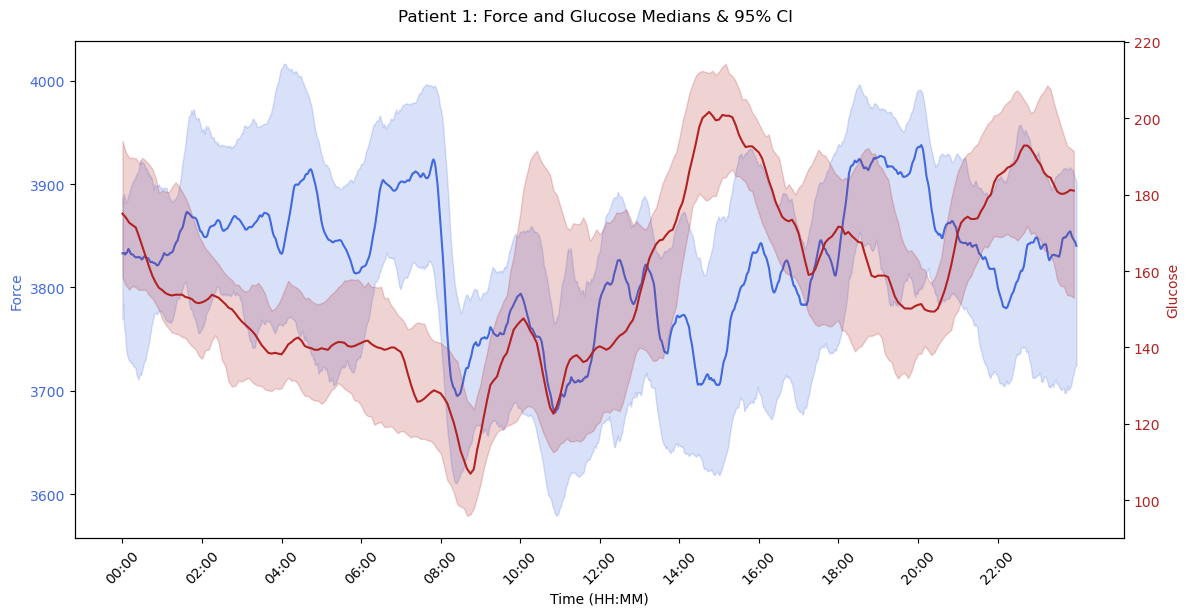

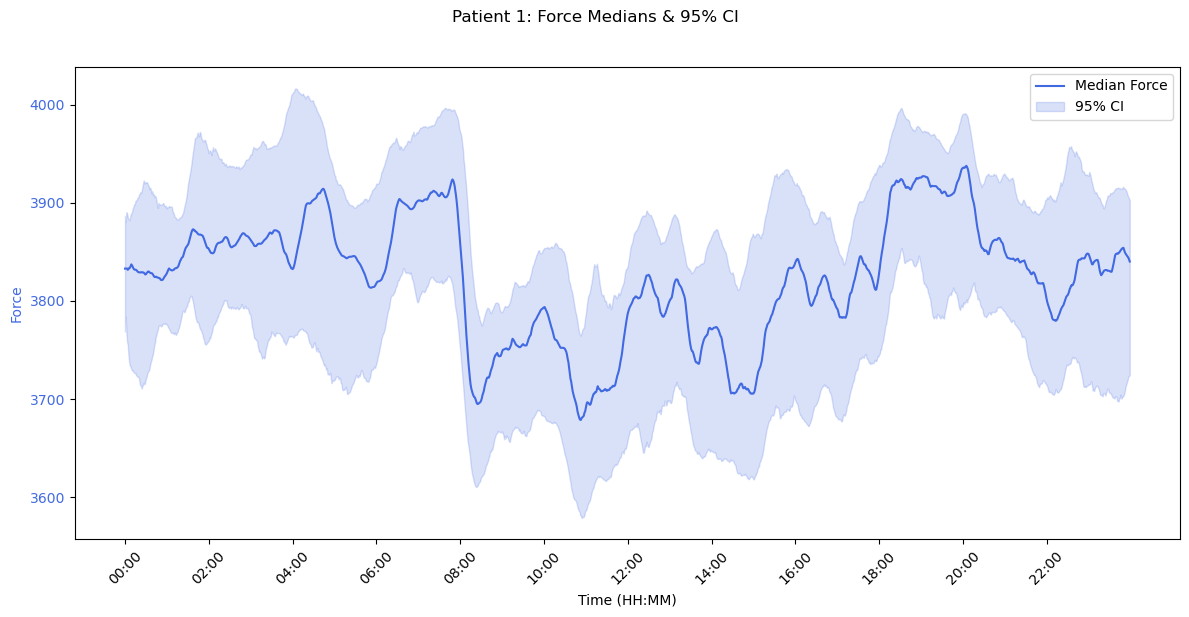

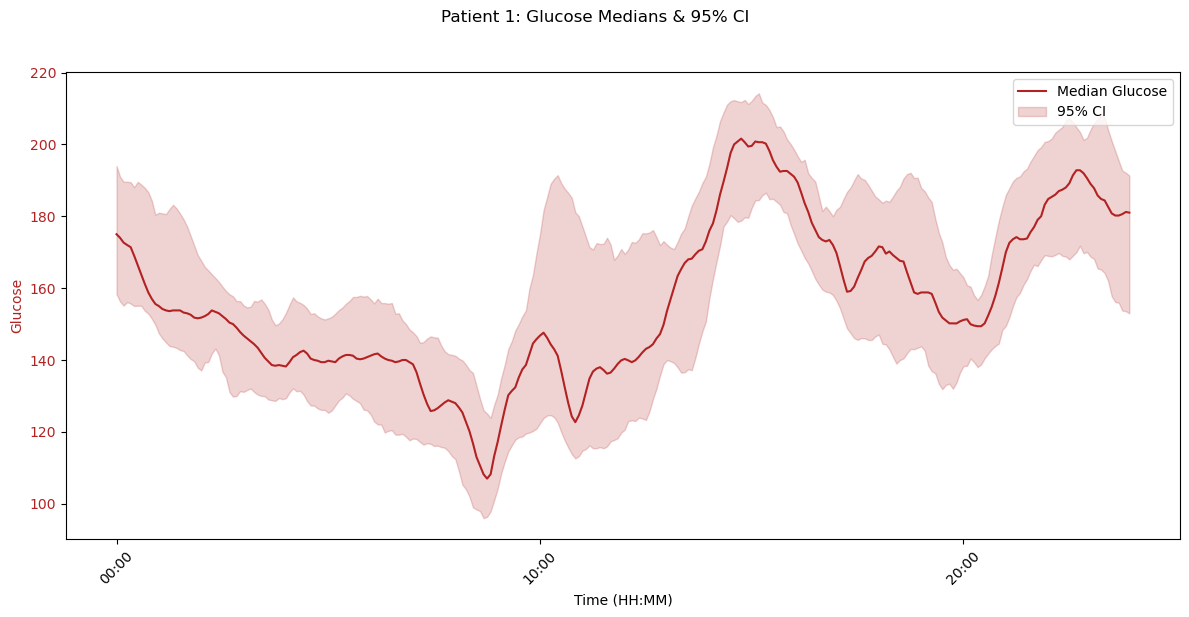

In [ ]:

glucose = pd.read_csv('')




glucose['timestamp'] = pd.to_datetime(glucose['timestamp'])

force.set_index('timestamp', inplace=True)
glucose.set_index('timestamp', inplace=True)

force_resampled = force.resample('T').mean().interpolate()
glucose_resampled = glucose.resample('5T').mean().interpolate()

force_resampled.reset_index(inplace=True)
glucose_resampled.reset_index(inplace=True)

force_resampled['time'] = force_resampled['timestamp'].dt.strftime('%H:%M')
glucose_resampled['time'] = glucose_resampled['timestamp'].dt.strftime('%H:%M')


def bootstrap_ci(data, num_samples=50, ci_percent=90):
    medians = []
    n = len(data)
    for _ in range(num_samples):
        resample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(resample))
    
    lower_bound = np.percentile(medians, (100 - ci_percent) / 2)
    upper_bound = np.percentile(medians, 100 - (100 - ci_percent) / 2)
    return lower_bound, upper_bound


window_size_force = 20  
window_size_glucose = 5 

force_summary = force_resampled.groupby('time')['force'].agg(['median']).reset_index()
force_summary['CI_lower'], force_summary['CI_upper'] = zip(*force_resampled.groupby('time')['force'].apply(lambda x: bootstrap_ci(x.values)))

glucose_summary = glucose_resampled.groupby('time')['glucose'].agg(['median']).reset_index()
glucose_summary['CI_lower'], glucose_summary['CI_upper'] = zip(*glucose_resampled.groupby('time')['glucose'].apply(lambda x: bootstrap_ci(x.values)))

force_summary['smoothed_median'] = force_summary['median'].rolling(window=window_size_force, min_periods=1).mean()
glucose_summary['smoothed_median'] = glucose_summary['median'].rolling(window=window_size_glucose, min_periods=1).mean()

force_summary['smoothed_CI_lower'] = force_summary['CI_lower'].rolling(window=window_size_force, min_periods=1).mean()
force_summary['smoothed_CI_upper'] = force_summary['CI_upper'].rolling(window=window_size_force, min_periods=1).mean()

glucose_summary['smoothed_CI_lower'] = glucose_summary['CI_lower'].rolling(window=window_size_glucose, min_periods=1).mean()
glucose_summary['smoothed_CI_upper'] = glucose_summary['CI_upper'].rolling(window=window_size_glucose, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(force_summary['time'], force_summary['smoothed_median'], color='royalblue', label='Smoothed Median Force')
ax1.fill_between(force_summary['time'], force_summary['smoothed_CI_lower'], force_summary['smoothed_CI_upper'], color='royalblue', alpha=0.2, label='95% CI Force')

ax1.set_xlabel('Time (HH:MM)')
ax1.set_ylabel('Force', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.set_xticks(force_summary['time'][::120])             
ax1.set_xticklabels(force_summary['time'][::120], rotation=45)
ax2 = ax1.twinx()
ax2.plot(glucose_summary['time'], glucose_summary['smoothed_median'], color='firebrick', label='Smoothed Median Glucose')
ax2.fill_between(glucose_summary['time'], glucose_summary['smoothed_CI_lower'], glucose_summary['smoothed_CI_upper'], color='firebrick', alpha=0.2, label='95% CI Glucose')

ax2.set_ylabel('Glucose', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

fig.tight_layout()
fig.suptitle(f'Patient {patient}: Force and Glucose Medians & 95% CI', y=1.02)

plt.show()

fig_force, ax_force = plt.subplots(figsize=(12, 6))

ax_force.plot(force_summary['time'], force_summary['smoothed_median'], color='royalblue', label='Median Force')
ax_force.fill_between(force_summary['time'], force_summary['smoothed_CI_lower'], force_summary['smoothed_CI_upper'], color='royalblue', alpha=0.2, label='95% CI')

ax_force.set_xlabel('Time (HH:MM)')
ax_force.set_ylabel('Force', color='royalblue')
ax_force.tick_params(axis='y', labelcolor='royalblue')
ax_force.set_xticks(force_summary['time'][::120]) 
ax_force.set_xticklabels(force_summary['time'][::120], rotation=45)

fig_force.suptitle(f'Patient {patient}: Force Medians & 95% CI', y=1.02)
ax_force.legend()

plt.tight_layout()
plt.show()

fig_glucose, ax_glucose = plt.subplots(figsize=(12, 6))

ax_glucose.plot(glucose_summary['time'], glucose_summary['smoothed_median'], color='firebrick', label='Median Glucose')
ax_glucose.fill_between(glucose_summary['time'], glucose_summary['smoothed_CI_lower'], glucose_summary['smoothed_CI_upper'], color='firebrick', alpha=0.2, label='95% CI')

ax_glucose.set_xlabel('Time (HH:MM)')
ax_glucose.set_ylabel('Glucose', color='firebrick')
ax_glucose.tick_params(axis='y', labelcolor='firebrick')
ax_glucose.set_xticks(glucose_summary['time'][::120])  
ax_glucose.set_xticklabels(glucose_summary['time'][::120], rotation=45)

fig_glucose.suptitle(f'Patient {patient}: Glucose Medians & 95% CI', y=1.02)
ax_glucose.legend()

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
import openpyxl as xl
from openpyxl.styles import PatternFill
green_fill = PatternFill(start_color="00FF00", end_color="00FF00", fill_type="solid")  # Green
red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid") 

Structure: 
day;-\
TIR higher than median;-\
TIR > 25th percentile;-\
Infusion set < 3 days;-\
Insulin intake smaller than median;-\
Insulin intake smaller than mean;-\
No glucose anomaly 2 sigmas away;-\
No glucose anomaly 3 sigmas away-.

One by one

In [ ]:

day_lista = []
day_one = start_day
for i in range(len(daily_percentages)):
    day_lista.append(day_one)
    day_one+=timedelta(days=1)

print(len(day_lista))


32


In [39]:
good_tir = []
median_tir = daily_percentages['percent_in_range'].median()

for day in daily_percentages['day']:
    percent_in_range_day = daily_percentages.loc[daily_percentages['day'] == day, 'percent_in_range'].values[0]
    if percent_in_range_day > median_tir:
        good_tir.append(1)
    else:
        good_tir.append(0)
print(len(good_tir))


32


In [40]:
percentile_25 = np.percentile(daily_percentages['percent_in_range'], 25)

medium_tir = []
for day in daily_percentages['day']:
    percent_in_range_day = daily_percentages.loc[daily_percentages['day'] == day, 'percent_in_range'].values[0]
    if percentile_25 < percent_in_range_day:
        medium_tir.append(1)
    else:
        medium_tir.append(0)

print(len(medium_tir))

32


In [44]:
insu_median = []
median_insu = daily_all['insulin'].median()

for day in daily_all['day']:
    insu_day = daily_all.loc[daily_all['day'] == day, 'insulin'].values[0]
    if insu_day < median_insu:
        insu_median.append(1)
    else:
        insu_median.append(0)
print(len(insu_median))


32


In [43]:
insu_mean = []
mean_insu = daily_all['insulin'].mean()

for day in daily_all['day']:
    insu_day = daily_all.loc[daily_all['day'] == day, 'insulin'].values[0]
    if insu_day < mean_insu:
        insu_mean.append(1)
    else:
        insu_mean.append(0)
print(len(insu_mean))

32


In [33]:
glucose_2_list = []
glucose_anomaly_2std = pd.read_excel("./2std-3std_away/outliers_2std.xlsx", sheet_name = 'Glucose Outliers')
glucose_anomaly_2std = glucose_anomaly_2std[glucose_anomaly_2std['patient']==patient]
if glucose_anomaly_2std.empty:
    glucose_2_list = [1] * len(medium_tir)
else:
    glucose_anomaly_2std['day']= glucose_anomaly_2std['timestamp'].dt.date
    day_one = force_start_day
    for i in range(len(medium_tir)):
        if (glucose_anomaly_2std['day'] == day_one).any():
            glucose_2_list.append(0)
        else:
            glucose_2_list.append(1)
        
        day_one += timedelta(days=1)
        
print(glucose_2_list)    

[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]


In [35]:
glucose_3_list = []
glucose_anomaly_3std = pd.read_excel("./2std-3std_away/outliers_3std.xlsx", sheet_name = 'Glucose Outliers')
glucose_anomaly_3std = glucose_anomaly_3std[glucose_anomaly_3std['patient']==patient]
if glucose_anomaly_3std.empty:
    glucose_3_list = [1] * len(medium_tir)
else:
    glucose_anomaly_3std['day']= glucose_anomaly_3std['timestamp'].dt.date
    day_one = force_start_day
    for i in range(len(medium_tir)):
        if (glucose_anomaly_3std['day'] == day_one).any():
            glucose_3_list.append(0)
        else:
            glucose_3_list.append(1)
        
        day_one += timedelta(days=1)
        
print(glucose_3_list)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]


In [ ]:
data_excel = {
    'day': day_lista,
    'TIR > Median': good_tir,
    'TIR > 25th percentile': medium_tir,
    'Insu < median': insu_median,
    'Insu < mean': insu_mean, 
    'CGM 2std': glucose_2_list,
    'CGM 3std':glucose_3_list
}
df_excel = pd.DataFrame(data_excel)

#df_excel['All green'] = df_excel.iloc[:, 2:15].apply(lambda row: 1 if (row.sum() == len(row)) else 0, axis=1)
#df_excel['One red'] = df_excel.iloc[:, 2:15].apply(lambda row: 1 if (row.sum() == len(row)-1) or (row.sum() == len(row)) else 0, axis=1)
#df_excel['Two red'] = df_excel.iloc[:, 2:15].apply(lambda row: 1 if (row.sum() == len(row)-2) or (row.sum() == len(row)-1) or (row.sum() == len(row)) else 0, axis=1)
print(df_excel)

In [ ]:
output_file = 'daily_evaluation.xlsx'
from openpyxl import Workbook, load_workbook
# Load the existing workbook, or create a new one if it doesn't exist
try:
    wb = load_workbook(output_file)
    ws = wb.active
except FileNotFoundError:
    wb = Workbook()
    ws = wb.active
    # If creating a new workbook, write the header
    headers = list(df_excel.columns)
    ws.append(headers)


for r_idx, row in enumerate(df_excel.itertuples(index=False), ws.max_row + 1):
    for c_idx, value in enumerate(row, 1):
        ws.cell(row=r_idx, column=c_idx, value=value)
        if c_idx > 1:
            if value == 1:
                ws.cell(row=r_idx, column=c_idx).fill = green_fill
            elif value == 0:
                ws.cell(row=r_idx, column=c_idx).fill = red_fill


wb.save(output_file)

print(f"New data appended to '{output_file}' with colored cells.")